In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params, optimization
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
                                   
from casting.utils import load_data
from casting.optimizer import BayesianOptimizer

from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다

font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')


cuda


# Preprocessing

### base

In [ ]:
# 데이터 불러오기
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')

# 사용하는 컬럼만 추출(보고서 내용 참고)
data = data_origin[columns.use_columns]

In [4]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)

## 이상치 제거
data = remove_outlier(data)

# 사용할 모델에 따른 전처리
if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# 디지털 트윈 모델

### 데이터 로드

In [5]:
# EXT 사용
train, valid, test = load_data(params.model_name)

### 모델링

In [6]:
# model_name에 일치하는 모델 학습
if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

### 추론

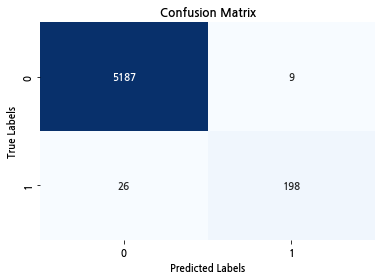

F1 Score: 0.9188
accuracy_score: 0.9935
precision_score: 0.9565
recall_score: 0.8839


In [7]:
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# 최적화 알고리즘

## Bayesian Optimization

In [ ]:
# 최적화 실행
optimizer = BayesianOptimizer(model, optimization)
results = optimizer.optimize_batch(test.drop(columns.target_column, axis=1))

Optimizing parameters:   1%|          | 44/5420 [00:41<1:18:43,  1.14it/s]

In [ ]:
# results csv 각 데이터포인트의 최적화된 제어값과 예측값 저장
# results.to_csv('/casting/results/action_bound_result', index=False)

Text(0.5, 1.0, 'upper_mold_temp2')

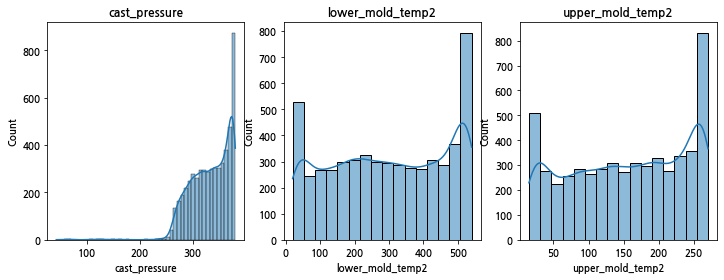

In [4]:
# cast_pressure, lower_mold_temp2, upper_mold_temp2 제어값 분포 plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)

sns.histplot(results['cast_pressure'], kde=True)
plt.title('cast_pressure')

plt.subplot(1, 3, 2)
sns.histplot(results['lower_mold_temp2'], kde=True)
plt.title('lower_mold_temp2')

plt.subplot(1, 3, 3)
sns.histplot(results['upper_mold_temp2'], kde=True)
plt.title('upper_mold_temp2')





In [10]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] = df['lower_mold_temp2']
X_test['cast_pressure'] = df['cast_pressure']
X_test['upper_mold_temp2'] = df['upper_mold_temp2']


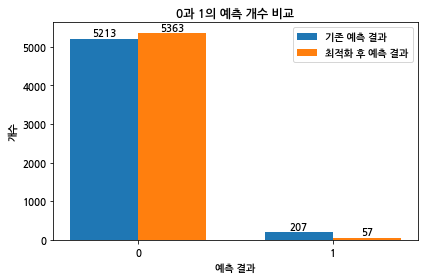

In [11]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()
